<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/deeplearning/blob/master/4/lab.ipynb">link</a>

# **Introduction**

In the beginning of this lab I wanted to complete it using YOLO alghorithm. However, when I read more resources I found proposed neural network architecture, that I should try to use. So I stick with this option.

<div style="align-items: center; justify-content: center">
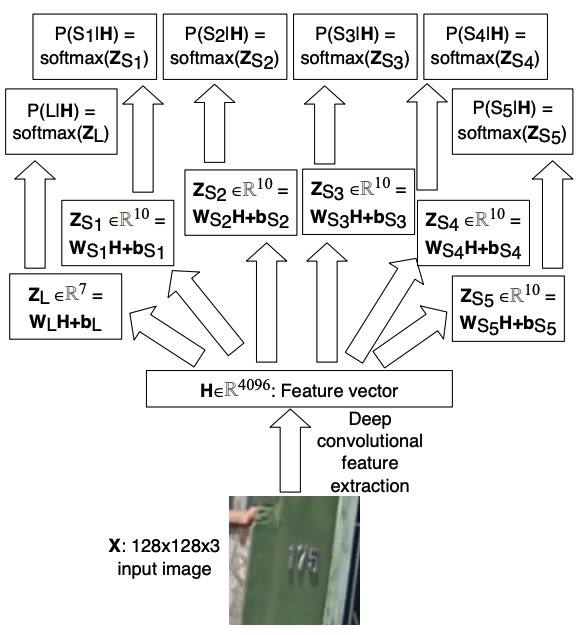</img>
<i style="align-items: center; justify-content: center">Picture 1 - proposed architecture of a neural network</i>
</div>

# **Part 1-1: Download and extract SVNH dataset**

Publication: https://arxiv.org/abs/1312.6082

In [0]:
!wget "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
!wget "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
!wget "http://ufldl.stanford.edu/housenumbers/extra_32x32.mat"

In [1]:
!wget "http://ufldl.stanford.edu/housenumbers/train.tar.gz"
!wget "http://ufldl.stanford.edu/housenumbers/test.tar.gz"
!wget "http://ufldl.stanford.edu/housenumbers/extra.tar.gz"

--2020-03-13 17:14:46--  http://ufldl.stanford.edu/housenumbers/train.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404141560 (385M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 385.42M  15.5MB/s    in 28s     

2020-03-13 17:15:15 (13.6 MB/s) - ‘train.tar.gz’ saved [404141560/404141560]

--2020-03-13 17:15:18--  http://ufldl.stanford.edu/housenumbers/test.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276555967 (264M) [application/x-gzip]
Saving to: ‘test.tar.gz’

test.tar.gz         100%[===================>] 263.74M  15.6MB/s    in 21s     

2020-03-13 17:15:39 (12.7 MB/s) - ‘test.tar.gz’ saved [276555967/2

Extract .zip

In [0]:
!mkdir train
!mkdir test
!mkdir extra
!tar xvzf train.tar.gz -C train
!tar xvzf test.tar.gz -C test
!tar xvzf extra.tar.gz -C extra

In [3]:
%ls

extra/  extra.tar.gz  sample_data/  test/  test.tar.gz  train/  train.tar.gz


Read data:

In [0]:
from scipy.io import loadmat

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
extra = loadmat('extra_32x32.mat')

X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

Check the data:

In [0]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (32, 32, 3, 73257)
y_train.shape:  (73257, 1)
X_test.shape:  (32, 32, 3, 26032)
y_test.shape:  (26032, 1)


Since we now know the structure of the data, we can visulize it:

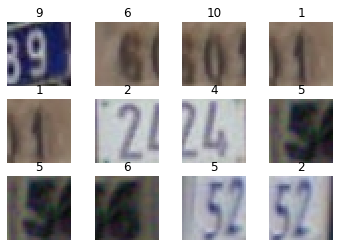

In [0]:
import matplotlib.pyplot as plt

X_train = X_train[:,:,:,:]
X_test = X_test[:,:,:,:]

start = 50

fig, ax = plt.subplots(3, 4)
for row in range(3):
    for col in range(4):
        ax[row, col].imshow(X_train[:,:,:,start+row*3+col])
        ax[row, col].axis('off')
        ax[row, col].set_title('{}'.format(y_train[start+row*3+col, 0]))
plt.show()

# **Common const definition:**

In [0]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

batch_size=32

In [0]:
import matplotlib.pyplot as plt

def show_images_with_labels(image_batch,label_batch):
    plt.figure(figsize=(10,10))
    for n in range(batch_size):
        ax = plt.subplot(4,8,n+1)
        plt.imshow(image_batch[n])
        length=label_batch[0][n]
        title=''.join([str(label_batch[c+1][n]) for c in range(length)])
        plt.title(title)
        plt.axis('off')

# **Part 1-2: Download and extract MNIST dataset**

In [2]:
from keras.datasets import mnist


# the data, split between train and test sets
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Normalizing the input
x_train_mnist= x_train_mnist.reshape(x_train_mnist.shape[0], 28, 28, 1) / 255
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0],28,28,1) / 255

Using TensorFlow backend.


Helper function:

In [0]:
import numpy as np
import cv2

def x_to_nn_input(X):
    x = np.reshape(X, (X.shape[0], 28, 28))
    x = np.asarray([cv2.resize(i, (IMAGE_WIDTH,IMAGE_HEIGHT)) for i in x], dtype=np.float32)
    x = np.repeat(x[..., np.newaxis], 3, -1)
    return x

In [4]:
x_to_nn_input(x_train_mnist[0:100]).shape

(100, 128, 128, 3)

Conversion for y value:

In [0]:
def y_mnist_to_NN_architecture_output(y):
  arr = [np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])]
  for i in range(6):
      for j in range(y.shape[0]):
          if i == 0:
              arr[0] = np.append(arr[0], int(1))
          if i == 1:
              arr[1] = np.append(arr[1], int(y[j]))
          if i >= 2:
              arr[i] = np.append(arr[i], int(NOT_A_NUMBER))
  return [i.astype(int) for i in arr]

In [0]:
y_mnist_to_NN_architecture_output(y_train_mnist)[0:32]

[array([1, 1, 1, ..., 1, 1, 1]),
 array([5, 0, 4, ..., 5, 6, 8]),
 array([10, 10, 10, ..., 10, 10, 10]),
 array([10, 10, 10, ..., 10, 10, 10]),
 array([10, 10, 10, ..., 10, 10, 10]),
 array([10, 10, 10, ..., 10, 10, 10])]

# **Part 1-3: Build a NN model**

NN model

In [19]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

input=Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), name="input")

H=Conv2D(16,(3,3),activation='relu',padding='same')(input)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same')(H)
H=Dropout(0.25)(H)

H=Conv2D(32,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same',strides=1)(H)
H=Dropout(0.25)(H)

H=Conv2D(48,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same')(H)
H=Dropout(0.25)(H)

H=Conv2D(64,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same',strides=1)(H)
H=Dropout(0.25)(H)

H=Conv2D(128,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same')(H)
H=Dropout(0.25)(H)

H=Conv2D(16,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same',strides=1)(H)
H=Dropout(0.25)(H)

H=Conv2D(16,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same')(H)
H=Dropout(0.25)(H)

H=Conv2D(16,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same',strides=1)(H)
H=Dropout(0.25)(H)

H=Flatten()(H)      
hidden10=Dense(4096, activation='relu')(H)
#H=Dropout(0.25)(H)
#hidden10=Dense(4096, activation='relu')(H)
#hidden10=Dropout(0.25)(H)

length=Dense(6, activation='softmax', name='length')(hidden10)
digit1=Dense(11, activation='softmax', name='digit1')(hidden10)
digit2=Dense(11, activation='softmax', name='digit2')(hidden10)
digit3=Dense(11, activation='softmax', name='digit3')(hidden10)
digit4=Dense(11, activation='softmax', name='digit4')(hidden10)
digit5=Dense(11, activation='softmax', name='digit5')(hidden10)

model = Model(inputs=input, outputs=[length,digit1,digit2,digit3,digit4,digit5], name='svhn_model')

model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc'])

model.summary()

Model: "svhn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 128, 128, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 128, 128, 16) 64          conv2d_70[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_70 (MaxPooling2D) (None, 64, 64, 16)   0           batch_normalization_70[0][0]     
_________________________________________________________________________________________

# **Part 1: Train on mnist dataset**

Const definition:

In [0]:
MAX_LENGTH = 5
NOT_A_NUMBER = 10

Data generator:

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=8, 
    width_shift_range=0.08, 
    shear_range=0.3, 
    height_shift_range=0.08, 
    zoom_range=0.08,
    rescale=1./255
)
test_gen = ImageDataGenerator(rescale=1./255)

training_set= train_gen.flow(
    x_to_nn_input(x_train_mnist), 
    y_mnist_to_NN_architecture_output(y_train_mnist), 
    batch_size=32
)

test_set= train_gen.flow(
    x_to_nn_input(x_test_mnist),
    y_mnist_to_NN_architecture_output(y_test_mnist),
    batch_size=32
 )

Show resized images:

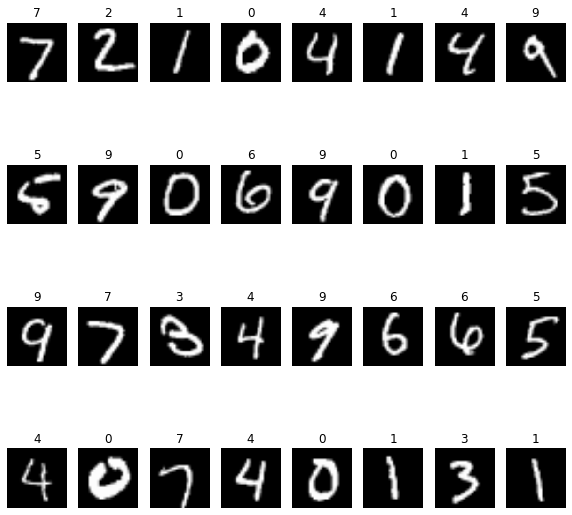

In [12]:
#image_batch, label_batch = next(train_gen)
show_images_with_labels(x_to_nn_input(x_test_mnist[0:32])[0:32], y_mnist_to_NN_architecture_output(y_test_mnist)[0:32])

NN train

In [21]:
X = x_to_nn_input(x_train_mnist[0:5000])
y = y_mnist_to_NN_architecture_output(y_train_mnist[0:5000])
Xt = x_to_nn_input(x_train_mnist[0:1000])
yt = y_mnist_to_NN_architecture_output(y_train_mnist[0:1000])

history = model.fit(
    X,
    y,
    validation_data=(Xt, yt),
    epochs=5,
    verbose=2
)

Train on 5000 samples, validate on 1000 samples
Epoch 1/5
5000/5000 - 22s - loss: 8.3469 - length_loss: 0.0048 - digit1_loss: 8.1836 - digit2_loss: 0.0204 - digit3_loss: 0.0216 - digit4_loss: 0.0426 - digit5_loss: 0.0366 - length_acc: 0.9980 - digit1_acc: 0.5320 - digit2_acc: 0.9940 - digit3_acc: 0.9938 - digit4_acc: 0.9936 - digit5_acc: 0.9936 - val_loss: 1742.6465 - val_length_loss: 0.0000e+00 - val_digit1_loss: 1723.5981 - val_digit2_loss: 0.0000e+00 - val_digit3_loss: 0.0000e+00 - val_digit4_loss: 0.0000e+00 - val_digit5_loss: 0.0000e+00 - val_length_acc: 1.0000 - val_digit1_acc: 0.1170 - val_digit2_acc: 1.0000 - val_digit3_acc: 1.0000 - val_digit4_acc: 1.0000 - val_digit5_acc: 1.0000
Epoch 2/5
5000/5000 - 20s - loss: 0.7481 - length_loss: 6.7513e-04 - digit1_loss: 0.7494 - digit2_loss: 9.6639e-04 - digit3_loss: 9.9039e-04 - digit4_loss: 9.5926e-04 - digit5_loss: 0.0010 - length_acc: 1.0000 - digit1_acc: 0.7660 - digit2_acc: 1.0000 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - digit5

# **Part 2: Train on svnh dataset**

Dataset preprocessing:

In [6]:
import h5py
import pandas as pd
import numpy as np

# The DigitStructFile is just a wrapper around the h5py data. It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struct data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    # getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self, n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    # bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self, attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    # Return a restructured version of the dataset.
    #
    #   Return a list of such dicts:
    #      'filename': filename of the samples
    #      'labels': list of such digits presented by an 6-array
    #
    # Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure(self):
        labels = []
        filenames=[]

        for i in range(len(self.digitStructBbox)):
            bbox = self.digitStructBbox[i].item()
            label_attribute = self.inf[bbox]['label']
            label = self.bboxHelper(label_attribute)
            # since one of the numbers has 6 numbers! (it is > 5)
            label = [0 if digit == 10 else digit for digit in label]
            length = len(label)
            name = self.getName(i)

            if (length > MAX_LENGTH):
                continue

            for _ in range(MAX_LENGTH - length):
                label.append(NOT_A_NUMBER)
            label.append(length)

            labels.append(label)
            filenames.append(name)

        return np.array(filenames), np.array(labels).astype(int)

    def to_dataframe(self):
        filenames, labels = self.getAllDigitStructure()

        return pd.DataFrame({
          'filename': filenames,
          'length': labels[:,5],
          'digit1': labels[:,0],
          'digit2': labels[:,1],
          'digit3': labels[:,2],
          'digit4': labels[:,3],
          'digit5': labels[:,4]
      })


df = DigitStructFile('train/train/digitStruct.mat').to_dataframe()

df.head()

,filename,length,digit1,digit2,digit3,digit4,digit5
0,1.png,2,1,9,10,10,10
1,2.png,2,2,3,10,10,10
2,3.png,2,2,5,10,10,10
3,4.png,2,9,3,10,10,10
4,5.png,2,3,1,10,10,10


Display one of the image:

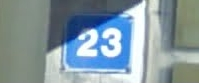

In [0]:
from IPython.display import Image

Image('train/train/2.png')

Dataset split

In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.10)

Image generator:

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# use data augmentation
train_datagen_aug = ImageDataGenerator(
      rotation_range=10,
      rescale=1./255,
      shear_range=0.1,
      zoom_range=0.1,
      width_shift_range=0.1,
      height_shift_range=0.1
)

test_gen = ImageDataGenerator(rescale=1./255)

Data flows:

In [9]:
TRAIN_PATH = 'train/train'
TEST_PATH = 'test/test'

y_col = ['length', 'digit1', 'digit2', 'digit3', 'digit4', 'digit5']
total_train = train.shape[0]
total_validate = val.shape[0]
batch_size = 32  # since Andrew Ng told, that better use 2^n

train_generator = train_datagen_aug.flow_from_dataframe(
    train, 
    TRAIN_PATH, 
    x_col='filename',
    y_col=y_col,
    target_size=IMAGE_SIZE,
    class_mode='multi_output',
    batch_size=batch_size
)

val_generator = test_gen.flow_from_dataframe(
    val, 
    TRAIN_PATH, 
    x_col='filename',
    y_col=y_col,
    target_size=IMAGE_SIZE,
    class_mode='multi_output',
    batch_size=batch_size
)

Found 30060 validated image filenames.
Found 3341 validated image filenames.


Show these examples:

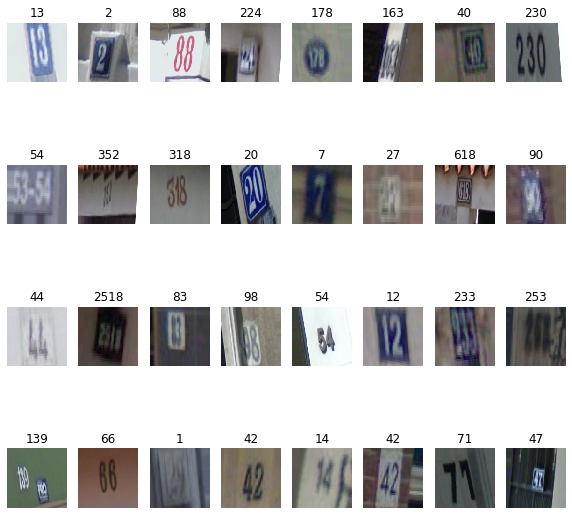

In [18]:
image_batch, label_batch = next(train_generator)
show_images_with_labels(image_batch, label_batch)

Train NN:

Upload **model.h5** file:

In [0]:
!rm model.h5

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [30]:
%ls 

adc.json  extra/        model2.h5     test/        train/
drive/    extra.tar.gz  sample_data/  test.tar.gz  train.tar.gz


In [31]:
model = load_model("drive/My Drive/model.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# define the checkpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit_generator(
    train_generator, 
    epochs=50,
    validation_data=val_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks_list
)

Epoch 1/50
104/939 [==>...........................] - ETA: 34s - loss: 7.1033 - length_loss: 0.9714 - digit1_loss: 2.1649 - digit2_loss: 2.3897 - digit3_loss: 1.2745 - digit4_loss: 0.2996 - digit5_loss: 0.0033 - length_acc: 0.5820 - digit1_acc: 0.2873 - digit2_acc: 0.2356 - digit3_acc: 0.6875 - digit4_acc: 0.9576 - digit5_acc: 0.9997
Epoch 00001: loss improved from inf to 6.93250, saving model to model.h5
939/939 [==============================] - 154s 164ms/step - loss: 6.9323 - length_loss: 0.9763 - digit1_loss: 2.0725 - digit2_loss: 2.3344 - digit3_loss: 1.2636 - digit4_loss: 0.2788 - digit5_loss: 0.0067 - length_acc: 0.5854 - digit1_acc: 0.2587 - digit2_acc: 0.1923 - digit3_acc: 0.6935 - digit4_acc: 0.9561 - digit5_acc: 0.9987 - val_loss: 7.1033 - val_length_loss: 0.9714 - val_digit1_loss: 2.1649 - val_digit2_loss: 2.3897 - val_digit3_loss: 1.2745 - val_digit4_loss: 0.2996 - val_digit5_loss: 0.0033 - val_length_acc: 0.5820 - val_digit1_acc: 0.2873 - val_digit2_acc: 0.2356 - val_dig

Applying test set processing

In [34]:
df_test = DigitStructFile('test/test/digitStruct.mat').to_dataframe()

test_generator = test_gen.flow_from_dataframe(
    df_test, 
    TEST_PATH, 
    x_col='filename',
    y_col=y_col,
    target_size=IMAGE_SIZE,
    class_mode='multi_output',
    batch_size=batch_size
)

Found 13068 validated image filenames.


In [35]:
results = model.evaluate(test_generator)

409/409 [==============================] - 27s 65ms/step - loss: 6.2810 - length_loss: 0.9711 - digit1_loss: 2.0121 - digit2_loss: 2.4037 - digit3_loss: 0.8046 - digit4_loss: 0.0882 - digit5_loss: 0.0014 - length_acc: 0.5455 - digit1_acc: 0.2827 - digit2_acc: 0.2082 - digit3_acc: 0.8294 - digit4_acc: 0.9887 - digit5_acc: 0.9998


In [36]:
print('Len acc: ', results[7])
print('Dig1 acc: ', results[8])
print('Dig2 acc: ', results[9])
print('Dig3 acc: ', results[10])
print('Dig4 acc: ', results[11])
print('Dig5 acc: ', results[12])

Len acc:  0.54545456
Dig1 acc:  0.28267524
Dig2 acc:  0.20821854
Dig3 acc:  0.8294307
Dig4 acc:  0.98867464
Dig5 acc:  0.99984694


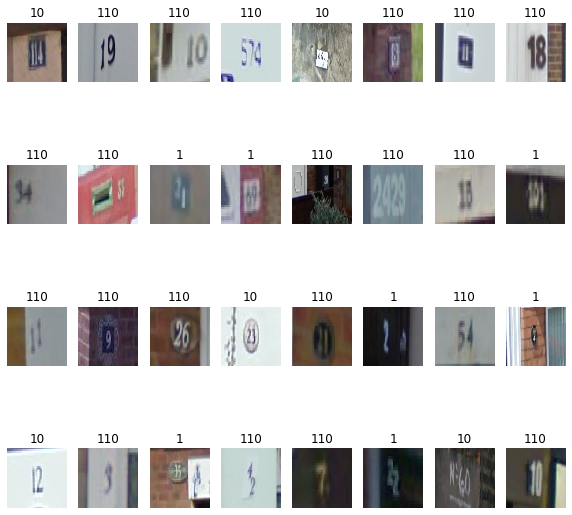

In [39]:
image_batch, label_batch = next(test_generator)

predict=model.predict(image_batch)

predicted_length=np.argmax(predict[0], axis=-1)
predicted_digit1=np.argmax(predict[1], axis=-1)
predicted_digit2=np.argmax(predict[2], axis=-1)
predicted_digit3=np.argmax(predict[3], axis=-1)
predicted_digit4=np.argmax(predict[4], axis=-1)
predicted_digit5=np.argmax(predict[5], axis=-1)

predicted_label=[predicted_length,predicted_digit1,predicted_digit2,predicted_digit3,predicted_digit4,predicted_digit5]

show_images_with_labels(image_batch, predicted_label)

# **Part 3: ?**

# **Part 4: Export model to tensorflow lite**

Convert model to tensorflow lite, in order to use it on weak devices:

In [0]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model_file('model.h5') 
tfmodel = converter.convert() 
open("model.tflite", "wb").write(tfmodel)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 64 variables.
INFO:tensorflow:Converted 64 variables to const ops.


84766588

Download lite model:

In [0]:
from google.colab import files

files.download('model.tflite') 

In [13]:
from google.colab import files

files.download('model.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 38990, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [40]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'model.h5'})
uploaded.SetContentFile('model.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1KkRE7f2-9cxf96wLqhsXrnbp5hwx2wBq


# **Afterward. Test result**

Write here about my results. Attach various screenshots.

# **Resources**

- Publication from youtube link: https://arxiv.org/abs/1312.6082
- https://github.com/penny4860/Yolo-digit-detector
- https://github.com/dyckia/SVHN-CNN/blob/master/SVHN.ipynb